# 1. 강의영상 

# 2. Imports

In [3]:
# import torch 
# from fastai.vision.all import *

# 3. GAN intro

`-` 저자: 이안굿펠로우 
- 천재임 
- 지도교수가 요수아 벤지오 

`-` 논문 NIPS, 저는 이 논문 읽고 소름돋았어요.. 
- https://arxiv.org/abs/1406.2661 (현재시점, 38751회 인용되었음 $\to$ 48978회 인용..)

`-` 최근 10년간 머신러닝 분야에서 가장 혁신적인 아이디어이다. (얀르쿤, 2014년 시점..) 

`-` 무슨내용? 생성모형 

## A. 생성모형이란? (쉬운 설명)

> 만들수 없다면 이해하지 못한 것이다, 리처드 파인만 (천재 물리학자) 

`-` 사진속에 들어있는 동물이 개인지 고양이인지 맞출수 있는 기계와 개와 고양이를 그릴수 있는 기계중 어떤것이 더 시각적보에 대한 이해가 깊다고 볼수 있는가? 

`-` 진정으로 인공지능이 이미지를 이해했다면, 이미지를 만들수도 있어야 한다. $\to$ 이미지를 생성하는 모형을 만들어보자 $\to$ 성공 

![](https://upload.wikimedia.org/wikipedia/commons/1/1f/Woman_1.jpg){width=70%}

## B. GAN의 응용분야

`-` 내가 찍은 사진이 피카소의 화풍으로 표현된다면?

`-` 퀸의 라이브에이드가 4k로 나온다면?

`-` 1920년대 서울의 모습이 칼라로 복원된다면? 

`-` 딥페이크: 유명인의 가짜 포르노, 가짜뉴스, 협박(거짓기소) 


`-` 게임영상 (파이널판타지)

`-` 거북이의 커버.. 

`-` 너무 많아요.....

## C. 생성모형이란? 통계학과 버전의 설명 

> 제한된 정보만으로 어떤 문제를 풀 때, 그 과정에서 원래의 문제보다 일반적인 문제를 풀지 말고, 가능한 원래의 문제를 직접 풀어야한다. 배프닉 (SVM 창시자) 

`-` 이미지 $\boldsymbol{x}$가 주어졌을 경우 라벨을 $y$라고 하자. 

`-` 이미지를 보고 라벨을 맞추는 일은 $p(y| \boldsymbol{x})$에 관심이 있다. 

`-` 이미지를 생성하는 일은 $p(\boldsymbol{x},y)$에 관심이 있는것이다. 

`-` 데이터의 생성확률 $p(\boldsymbol{x},y)$을 알면 클래스의 사후확률 $p(y|\boldsymbol{x})$를 알 수 있음. (아래의 수식 참고) 하지만 역은 불가능 

$$p(y|x) = \frac{p(x,y)}{p(x)} = \frac{p(x,y)}{\sum_{y}p(x,y)} $$

- 즉 이미지를 생성하는일은 분류문제보다 더 어려운 일이라 해석가능 

`-` 따라서 배프닉의 원리에 의하면 식별적 분류가 생성적 분류보다 바람직한 접근법이라 할 수 있음. 

`-` 하지만 다양한 현실문제에서 생성모형이 유용할때가 많다. 

## D. GAN의 원리

`-` GAN은 생성모형중 하나임 

`-` GAN의 원리는 경찰과 위조지폐범이 서로 선의의(?) 경쟁을 통하여 서로 발전하는 모형으로 설명할 수 있다. 

> The generative model can be thought of as analogous to a team of counterfeiters,
trying to produce fake currency and use it without detection, while the discriminative model is
analogous to the police, trying to detect the counterfeit currency. Competition in this game drives
both teams to improve their methods until the counterfeits are indistiguishable from the genuine
articles.

`-` 서로 적대적인(adversarial) 네트워크(network)를 동시에 학습시켜 가짜이미지를 만든다(generate) 

`-` 무식한 상황극.. 

- 위조범: 가짜돈을 만들어서 부자가 되어야지! (가짜돈을 그림) 
- 경찰: (위조범이 만든 돈을 보고) 이건 가짜다! 
- 위조범: 걸렸군.. 더 정교하게 만들어야지.. 
- 경찰: 이건 진짠가?... --> 상사에게 혼남. 그것도 구분못하냐고 
- 위조범: 더 정교하게 만들자.. 
- 경찰: 더 판별능력을 업그레이드 하자! 
- 반복.. 

`-` 굉장히 우수한 경찰조차도 진짜와 가짜를 구분하지 못할때(=진짜 이미지를 0.5의 확률로만 진짜라고 말할때 = 가짜 이미지를 0.5의 확률로만 가짜라고 말할때) 학습을 멈춘다. 

# 4. GAN의 구현

## A. Data 

In [159]:
path = untar_data(URLs.MNIST_SAMPLE)

In [160]:
threes = (path/'train'/'3').ls()

In [161]:
X = torch.stack([tensor(Image.open(i)) for i in threes]).float()/255

In [162]:
X.shape

torch.Size([6131, 28, 28])

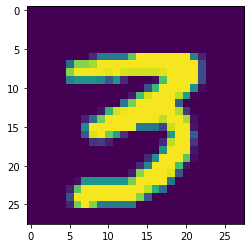

In [163]:
plt.imshow(X[0])

`-` MLP를 이용해 학습하기 위해 X의 차원을 변경

In [164]:
X=X.reshape(6131,28*28)
X.shape

torch.Size([6131, 784])

## B. 위조지폐범의 설계: noise $\to$ 가짜이미지를 만들어 내는 네트워크를 만들자. 

`-` 네트워크의 입력? 적당한 벡터, 혹은 매트릭스에 노이즈(랜덤으로 채운 어떠한 숫자들)를 채운것 

`-` 네트워크의 출력? (28,28)의 텐서, 784의 벡터 

In [165]:
net1 = torch.nn.Sequential(torch.nn.Linear(in_features=28, out_features=64),
                           torch.nn.ReLU(),
                           torch.nn.Linear(in_features=64, out_features=64), 
                           torch.nn.ReLU(),
                           torch.nn.Linear(in_features=64, out_features=784),
                           torch.nn.Sigmoid()) ## 마지막의 시그모이드는 출력이 0~1사이로 나오게 하기 위함 
counterfeiter = net1 

## C. 경찰의 설계: 진짜이미지는 1, 가짜이미지는 0으로 판별하는 DNN을 만들자. 

`-` 네트워크의 입력? (28,28)의 텐서, 혹은 784의 벡터 

`-` 네트워크의 출력? yhat (y는 0 or 1)

In [166]:
net2 = torch.nn.Sequential(torch.nn.Linear(in_features=784,out_features=64),
                           torch.nn.ReLU(),
                           torch.nn.Linear(in_features=64,out_features=28),
                           torch.nn.ReLU(),
                           torch.nn.Linear(in_features=28,out_features=1),
                           torch.nn.Sigmoid()
                           )
police = net2 

## D. 바보들끼리.. 

`-` 아래는 진짜이미지 

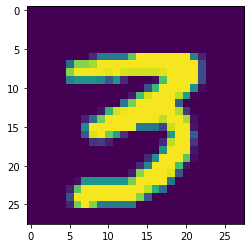

In [167]:
realimage=X[0].reshape(28,28)
plt.imshow(realimage)

`-` 위와 같은 진짜 이미지를 경찰이 봤음 $\to$ yhat이 나오겠죠? 

In [168]:
policehat_from_realimage = police(realimage.reshape(-1))
policehat_from_realimage

tensor([0.5241], grad_fn=<SigmoidBackward0>)

- 진짜 이미지일수록 policehat_from_realimage $\approx$ 1 이어야 함 
- 하지만 그렇지 못함 (배운것이 없는 무능한 경찰) 

`-` 이번에는 가짜이미지를 경찰이 봤다고 생각해보자. 

(step1) 랜덤으로 아무숫자나 28개를 생성한다. 

In [169]:
err= torch.randn(28)
err

tensor([-0.8568, -2.2982,  0.3489, -1.5801,  1.8611,  0.9158, -0.2985,  1.1087,
         1.3798,  1.4870, -0.4455,  0.2140,  1.0784,  1.4805, -1.4886,  0.5036,
         0.3742, -0.7351,  1.0031,  0.4538,  1.5372,  1.0739,  0.7793, -1.5347,
        -0.5060,  0.0113,  0.2833, -0.8466])

(step2) 위조범은 err를 입력으로 받고 가짜이미지를 만든다. 

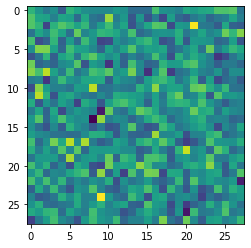

In [170]:
couterfeiter_output = counterfeiter(err)
fakeimage=couterfeiter_output.reshape(28,28)
plt.imshow(fakeimage.detach())

- 누가봐도 가짜자료임
- 위조범의 실력이 형편없음 

(step3) 위조범이 생성한 이미지를 경찰한테 넘긴다. 

In [171]:
policehat_from_fakeimage = police(couterfeiter_output)
#policehat_from_fakeimage = police(fakeimage.detach().reshape(-1))
policehat_from_fakeimage

tensor([0.5290], grad_fn=<SigmoidBackward0>)

`-` 경찰의 실력도 형편없고 위조범의 실력도 형편없다. 

## E. 경찰네트워크의 실력을 향상시키자. 

`-` 데이터 정리 
- 원래 $n=6131$개의 이미지 자료가 있음. 이를 ${\bf X}$라고 하자. 따라서 ${\bf X}$의 차원은 (6131,784). 
- 위조범이 만든 가짜자료를 원래 자료와 같은 숫자인 6131개 만듬. 이 가짜자료를 $\tilde{\bf X}$라고 하자. 따라서 $\tilde{\bf X}$의 차원은 (6131,784). 
- 진짜자료는 1, 가짜자료는 0으로 라벨링. 

In [172]:
X.shape

torch.Size([6131, 784])

In [173]:
err= torch.randn(6131,28)
counterfeiter_output = counterfeiter(err) # counterfeiter_output를 Xtilde로 생각하면 된다. 

In [174]:
real_label=torch.tensor([[1.0]]*6131) ## y=1 
fake_label=torch.tensor([[0.0]]*6131) ## y=0

`-` step1: yhat, 경찰의 예측 

In [175]:
policehat_from_realimage = police(X) 
policehat_from_fakeimage = police(counterfeiter_output) 

`-` step2: 손실함수? 경찰의 미덕은 (1) 가짜를 가짜라고 하고 (2) 진짜를 진짜라 해야한다. 

In [176]:
loss_fn = torch.nn.BCELoss() 

In [181]:
loss_of_police =\
loss_fn(policehat_from_fakeimage,fake_label)+\
loss_fn(policehat_from_realimage,real_label)

loss_of_police

tensor(1.4023, grad_fn=<AddBackward0>)

`-` step3~4는 미분이후 업데이트 

`-` 옵티마이저를 설계하자. 

In [182]:
optimizer_of_police = torch.optim.Adam(police.parameters())

`-` for 문을 돌리자. 

In [183]:
for i in range(50): 
    ## 1 yhat 
    policehat_from_realimage = police(X) 
    
    #policehat_from_fakeimage = police(Xitlde)
    err= torch.randn(6131,28)
    counterfeiter_output = counterfeiter(err) # counterfeiter_output를 Xtilde로 생각하면 된다. 
    policehat_from_fakeimage= police(counterfeiter_output)
    
    ## 2 loss 
    loss_of_police =\
    loss_fn(policehat_from_fakeimage,fake_label)+\
    loss_fn(policehat_from_realimage,real_label)
    
    ## 3 back propagation 
    loss_of_police.backward()
    
    ## 4 update
    optimizer_of_police.step()
    optimizer_of_police.zero_grad()

`-` 훈련된 경찰의 성능을 살펴보자. 

In [185]:
police(counterfeiter_output)

tensor([[0.0061],
        [0.0061],
        [0.0061],
        ...,
        [0.0062],
        [0.0061],
        [0.0061]], grad_fn=<SigmoidBackward0>)

In [186]:
police(X)

tensor([[0.9999],
        [0.9989],
        [0.9995],
        ...,
        [0.9969],
        [0.9995],
        [0.9973]], grad_fn=<SigmoidBackward0>)

`-` 우수한 경찰 (비록 위조범의 수준이 낮긴하지만) 

## F. 위조범네트워크의 성능을 향상시키자. 

`-` 자료구조: X는 임의의 에러이미지, net(X)는 fakeimage 

In [187]:
err=torch.randn(6131,28) 
counterfeiter_output= counterfeiter(err) 

`-` 손실함수: 잘 훈련된 경찰조차도 잘못된 판단을 내릴만큼 가짜지폐를 잘 만들면 위조범의 실력이 우수하다 볼 수 있음 

In [188]:
policehat_from_fakeimage = police(counterfeiter_output) 
loss_of_counterfeiter = loss_fn(policehat_from_fakeimage,real_label) ## 가짜이미지를 보고 경찰이 진짜라고 믿으면 위조범의 실력이 좋은것임  

`-` 옵티마이저 

In [189]:
optimizer_of_counterfeiter = torch.optim.Adam(counterfeiter.parameters())

`-` 학습

In [190]:
for i in range(50): 
    ## 1 
    err=torch.randn(6131,28) 
    counterfeiter_output= counterfeiter(err)  
    policehat_from_fakeimage = police(counterfeiter_output) 
    ## 2 
    loss_of_counterfeiter = loss_fn(policehat_from_fakeimage,real_label)
    ## 3 
    loss_of_counterfeiter.backward()
    ## 4 
    optimizer_of_counterfeiter.step()
    optimizer_of_counterfeiter.zero_grad()

`-` 위조범의 실력향상을 감상해보자. 

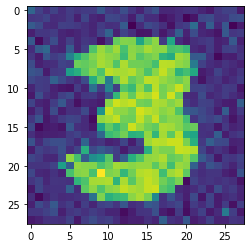

In [195]:
plt.imshow(counterfeiter_output[0].reshape(28,28).data)

## G. 두 적대적 네트워크를 경쟁시키자. 

In [196]:
for k in range(100): 
    for i in range(50): 
        ## 1 yhat 
        policehat_from_realimage = police(X) 
    
        #policehat_from_fakeimage = police(Xitlde)
        err= torch.randn(6131,28)
        counterfeiter_output = counterfeiter(err) # counterfeiter_output를 Xtilde로 생각하면 된다. 
        policehat_from_fakeimage= police(counterfeiter_output)
    
        ## 2 loss 
        loss_of_police =\
        loss_fn(policehat_from_fakeimage,fake_label)+\
        loss_fn(policehat_from_realimage,real_label)
    
        ## 3 back propagation 
        loss_of_police.backward()
    
        ## 4 update
        optimizer_of_police.step()
        optimizer_of_police.zero_grad()
        
    for i in range(50): 
        ## 1 
        err=torch.randn(6131,28) 
        counterfeiter_output= counterfeiter(err)  
        policehat_from_fakeimage = police(counterfeiter_output) 
        ## 2 
        loss_of_counterfeiter = loss_fn(policehat_from_fakeimage,real_label)
        ## 3 
        loss_of_counterfeiter.backward()
        ## 4 
        optimizer_of_counterfeiter.step()
        optimizer_of_counterfeiter.zero_grad()        

`-` 위조범의 최종적 실력향상감상 

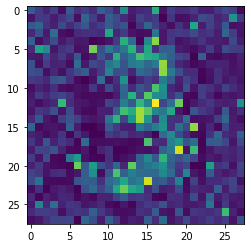

In [198]:
plt.imshow(counterfeiter_output[0].reshape(28,28).data)